In [ ]:
!pip install openai==0.28
!pip install -q tiktoken


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import tiktoken
import pandas as pd
import numpy as np
import os
from openpyxl.utils import get_column_letter
#import backoff
import google.generativeai as genai
import time

# Function to ask for the preference on time preference
def get_time_preference(Context, model):
    import  openai
    # Set API credentials and custom endpoint
    openai.api_key = 'api-key'
    openai.api_base = 'api-source'

    # Build the prompt
    prompt = f"""
{Context}


Question 1: Which option would you prefer?
A. 20 cents that you receive in 1 week
B. 20 cents that you receive in 4 weeks

Question 2: Which option would you prefer?
A. 19 cents that you receive in 1 week
B. 20 cents that you receive in 4 weeks

Question 3: Which option would you prefer?
A. 18 cents that you receive in 1 week
B. 20 cents that you receive in 4 weeks

Question 4: Which option would you prefer?
A. 17 cents that you receive in 1 week
B. 20 cents that you receive in 4 weeks

Question 5: Which option would you prefer?
A. 16 cents that you receive in 1 week
B. 20 cents that you receive in 4 weeks

Question 6: Which option would you prefer?
A. 15 cents that you receive in 1 week
B. 20 cents that you receive in 4 weeks

Question 7: Which option would you prefer?
A. 14 cents that you receive in 1 week
B. 20 cents that you receive in 4 weeks

Question 8: Which option would you prefer?
A. 13 cents that you receive in 1 week
B. 20 cents that you receive in 4 weeks

Indicate the number of the question (between 1 and 8) where you first switch to choosing Option B. Please only return the number, NOTHING ELSE!
"""

    attempt = 0
    retries = 5

    while attempt < retries:
        try:
            response = openai.ChatCompletion.create(
                model=model,
                prompt=prompt,
                messages=[
                    {"role": "user", "content": prompt}
                ],
                enable_thinking=False,
                temperature=1.0,
            )

            attempt=6
        except openai.error.OpenAIError as e:  # Handle specific OpenAI API errors
            attempt += 1
            wait_time = (2 ** (attempt - 1))  # Exponential backoff calculation
            print(f"Attempt {attempt} failed: {e}. Retrying in {wait_time} seconds...")
            time.sleep(wait_time)  # Sleep before retrying
            if attempt == retries:
                print("Max retries reached. Request failed.")

    # Return cleaned response
    del openai
    #print(response.choices[0].text.strip())
    print(response.choices[0].message.content)
    if model == "gemma-3-27b-it":
      time.sleep(3)
    # print(len(tiktoken.encoding_for_model('gpt-4o').encode(prompt)))
    #return response.choices[0].text.strip(), len(tiktoken.encoding_for_model('gpt-4o').encode(prompt))
    return response.choices[0].message.content, len(tiktoken.encoding_for_model('gpt-4o').encode(prompt))



def update_statistics(file_name, character, prompt, promptid, promptlegond, model):

    # Load the time preference answers file
    file_path = os.path.join(directory, file_name)
    time_preference_df = pd.read_excel(file_path)

    # Load the Excel file again to update specific cells
    file_path = os.path.join(directory, "OverallColabv8.xlsx")
    overall_df = pd.read_excel(file_path, sheet_name="rowtdf")

    deltabeta_mapping = dict(zip(overall_df.iloc[:, 0], overall_df.iloc[:, 1]))  # Adjust column indexing as needed
    deltabeta = time_preference_df['Answer'].map(deltabeta_mapping)

    ctokens = time_preference_df['tokens']

    #deltabeta = time_preference_df['Answer'] * overall_df['deltabeta']  # Modify based on actual columns

    # Define the full file path
    file_path = os.path.join(directory, "test.xlsx")

    # Save the deltabeta to the Excel file
    deltabeta.to_excel(file_path, index=False)

    file_path = os.path.join(directory, "OverallColabv8.xlsx")
    sheet_name = 'DB'

    # Load the existing data from the DB sheet
    df = pd.read_excel(file_path, sheet_name=sheet_name)

    # Get the last record's index
    last_record = df.iloc[-1]

    # Calculate the next record number
    next_record_number = last_record['record'] + 1 if len(df) > 0 else 1

    # Set the temperature, model, and deltabeta
    tempreture = 1

    from datetime import datetime
    # Get the current date and time
    current_datetime = datetime.now()

    # Prepare the new records to be added
    new_records = []
    for i in range(len(deltabeta)):
        new_record = {
            'record': next_record_number + i,
            'prompt_id': promptid,
            'temp': tempreture,
            'model': model,
            'deltabeta': deltabeta[i],
            'ctokens': ctokens[i],
            'date': current_datetime
        }
        new_records.append(new_record)

    # Convert the list of new records to a DataFrame
    new_df = pd.DataFrame(new_records)

    # Append the new DataFrame to the existing DataFrame
    df = pd.concat([df, new_df], ignore_index=True)

    # Write the updated DataFrame back to the Excel file
    with pd.ExcelWriter(file_path, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        df.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Added {len(new_records)} new records to the DB sheet.")


    print("Statistics have been updated successfully!")



def context_result_gen(context, file_name, model):
    # Ask the question nn times and store the answers
    answers = []
    tokens = []
    nn=2
    for i in range(nn):
        answer, token = get_time_preference(context, model)
        answers.append(answer)
        tokens.append(token)

    if not os.path.exists(directory):
        os.makedirs(directory)  # Create the directory if it does not exist

    # Create a DataFrame with the answers
    df = pd.DataFrame({
        "Answer Number": [i + 1 for i in range(nn)],
        "Answer": answers,
        "tokens": tokens
    })

    # Define the full file path
    file_path = os.path.join(directory, file_name )
    # file_path = "C:/Personal/Ongoing Projects/Fara/Papers/time preferences/time_preference_answers.xlsx"  # Change to your desired path


    # Save the answers to the Excel file
    df.to_excel(file_path, index=False)
    print(f"\nAll answers have been saved to {file_path}")



import string

directory = "/content/drive/MyDrive/Colab Notebooks"  # Update this with the specific path

# letters = list(string.ascii_uppercase)
file_path = os.path.join(directory, "Prompts list.xlsx")
wbb = pd.read_excel(file_path, sheet_name="Promptsstock")

# Define the list of desired id_prompt values
desired_ids = ['v1-53', 'v1-54', 'v1-55', 'v1-56', 'v1-57', 'v1-59', 'v1-64', 'v1-65', 'v1-66', 'v1-67', 'v1-68', 'v1-69', 'v1-70']

# Filter the DataFrame
wb = wbb[wbb['id_prompt'].isin(desired_ids)]
wb = wb.reset_index(drop=True)

#model_list = ["gpt-4o-2024-11-20", "gpt-4.1-nano", "deepseek-chat", "meta.llama3-1-70b-instruct-v1:0", "meta.llama3-1-8b-instruct-v1:0", "grok-3", "grok-3-mini", "gemini-2.0-flash-lite", "deepseek-reasoner", "gemma-3-27b-it"]
#model_list = ["gpt-4.1-nano", "deepseek-chat", "meta.llama3-1-70b-instruct-v1:0", "meta.llama3-1-8b-instruct-v1:0", "grok-3", "grok-3-mini", "gemini-2.0-flash-lite", "deepseek-reasoner", "gemma-3-27b-it"]
#model_list = ["deepseek-reasoner", "gemma-3-27b-it"]
model_list = ["qwen3-235b-a22b", "qwen3-4b"]


#model_list = ["gpt-4.1-nano", "deepseek-chat", "meta.llama3-1-70b-instruct-v1:0", "meta.llama3-1-8b-instruct-v1:0", "grok-3", "grok-3-mini", "gemini-2.0-flash-lite"]
ni = 23  # number of total repetitions of the whole block

for _ in range(ni):  # repeat the whole block ni times
    print(_)
    for model in model_list:
        for i in range(len(wb)):
            print(model)
            context_result_gen(wb.loc[i, 'prompt'], "time_preference_answers.xlsx", model)
            update_statistics(
                "time_preference_answers.xlsx",
                get_column_letter(i + 2),
                wb.loc[i, 'prompt'],
                wb.loc[i, 'id_prompt'],
                wb.loc[i, 'legond'],
                model
            )


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
from openpyxl.utils import get_column_letter
import seaborn as sns

# Update this with the specific path
directory = "/content/drive/MyDrive/Colab Notebooks"

file_path = os.path.join(directory, "Prompts list.xlsx")
wbb = pd.read_excel(file_path, sheet_name="Promptsstock")

# Replace 'directory' with the correct path if not already set
file_path = os.path.join(directory, "OverallColabv8.xlsx")

# Define the list of desired id_prompt values
desired_ids = ['v1-53', 'v1-54', 'v1-55', 'v1-56', 'v1-57', 'v1-59', 'v1-64', 'v1-65', 'v1-66', 'v1-67', 'v1-68', 'v1-69', 'v1-70']
models = ['deepseek-reasoner',
          'meta.llama3-1-70b-instruct-v1:0',
          'grok-3',
          'gemini-2.0-flash-lite',
          'gpt-4o-2024-11-20',
          'gpt-4.1-nano',
          'deepseek-chat',
          'meta.llama3-1-8b-instruct-v1:0',
          'grok-3-mini',
          'gemma-3-27b-it']
# Select the model for the intended figure here
models = ['deepseek-chat']

# Read the DB
dbb = pd.read_excel(file_path, sheet_name="DB")

# Loop over each unique model in the 'DB' sheet
for model in models:
    try:
        # Filter the DB and Promptsstock DataFrames by the current model
        dbb_model = dbb[dbb['model'] == model]
        wbb_model = wbb[wbb['id_prompt'].isin(dbb_model['prompt_id'].unique())]

        with pd.ExcelWriter(file_path, engine='openpyxl', mode='a') as writer:
            book = writer.book

            # Step 1: Delete the 'Datatfigure' sheet if it exists
            if 'Datatfigure' in book.sheetnames:
                del book['Datatfigure']

            # Step 2: Copy the 'Olgoo' sheet and rename it to 'Datatfigure'
            olgoo_sheet = book['Olgoo']
            new_sheet = book.copy_worksheet(olgoo_sheet)
            new_sheet.title = 'Datatfigure'  # Renaming the copied sheet

            # Now proceed with the rest of the code
            sheet = book['Datatfigure']

            # Loop through the desired IDs to update the Excel sheet
            for i, id_value in enumerate(desired_ids):
                wb = wbb_model[wbb_model['id_prompt'] == id_value]
                wb = wb.reset_index(drop=True)
                dbd = dbb_model[dbb_model['prompt_id'] == id_value]
                dbd = dbd.reset_index(drop=True)

                # Update the cells in the 'Datatfigure' sheet
                character = get_column_letter(i + 6)  # The +6 makes it start at column F

                # Update the cells
                if not wb.empty:
                    sheet[f'{character}9'] = wb.loc[0, 'legond']  # Writing the 'legond' value
                else:
                    sheet[f'{character}9'] = None  # If 'wb' is empty, leave it blank

                # Handle 'deltabeta' column, accounting for variable length
                if not dbd.empty:
                    for idx, value in enumerate(dbd['deltabeta']):
                        try:
                            sheet[f'{character}{10 + idx}'] = value
                        except Exception as e:
                            print(e)
                else:
                    sheet[f'{character}10'] = None  # If 'dbd' is empty, leave it blank

            # Step 3: Apply scaling to the data
            character = get_column_letter(len(desired_ids) + 5)

            # Read the first few rows to dynamically get the available columns
            temp_data = pd.read_excel(file_path, sheet_name='Datatfigure', header=0, nrows=5)

            columns_range = f'A:{character}'  # Adjust column range dynamically
            # Read the data from the specified range in Excel (Sheet name, cells A9 to last column)
            data = pd.read_excel(file_path, sheet_name='Datatfigure', header=0, usecols=f'A:{character}', skiprows=8)

            scaled_df = data.drop(columns=['Human-Male', 'Human-Female', 'Human-Male-p', 'Human-Female-p'])
            # Assuming the data is in `scaled_df` and has the proper columns for categories
            # Update the color palette for all categories
            category_colors = {
                "AI-u r human": "skyblue",
                "AI": "skyblue",  # Same color as "AI-u r human"
                "Male": "lightgreen",
                "Female": "lightcoral",
                "USA": "lightyellow",
                "No Context": "lightgrey",
                "Future manipulation": "lightpink",
                "Human": "lightgreen",
                "Chain of Thought": "orange",
                "forget AI-u r human": "skyblue",  # Same as "AI-u r human"
                "Europe": "lightblue",
                "Finance minister": "gold",
                "Present manipulation": "lightcoral",
                "Iran": "lightgreen",
                "Disaster-forget AI-u r human": "skyblue",  # Same as "AI-u r human"
            }

            # Create the figure and set the size
            plt.figure(figsize=(14, 8))  # Increased figure size to avoid overlap

            # Prepare data for the violin plot
            # If the categories are already present in your `scaled_df`, you can use them directly
            # Ensure the data is in a 'long-form' structure for Seaborn

            # Create a new DataFrame with 'Category' column to specify the groupings
            data_long = pd.melt(scaled_df, var_name='Category', value_name='Discount Factor')

            # Create the violin plot with different colors using the `category_colors` palette
            #sns.violinplot(x='Category', y='Discount Factor', data=data_long, palette=category_colors)
            sns.violinplot(x='Category', y='Discount Factor', data=data_long, hue='Category', palette=category_colors, legend=False)

            # Calculate the mean for each category (similar to how you did before)
            means = scaled_df.mean()

            # Plot the mean line as a time series with a label
            plt.plot(range(0, len(scaled_df.columns)), means, marker='o', color='blue', linestyle='-', linewidth=2, markersize=8, label='Mean')

            # Title and labels
            plt.title(f"Model {model}", fontsize=16, fontweight='bold')
            plt.ylabel("Discount Factor", fontsize=14, fontweight='bold')

            # Adding x-axis labels and rotating them obliquely (45 degrees)
            plt.xticks(ticks=range(0, len(scaled_df.columns)),
                      labels=scaled_df.columns,
                      rotation=45,
                      fontsize=12,
                      fontweight='bold',
                      ha='right',  # Align the labels to the right
                      rotation_mode='anchor')  # Prevent label overlapping

            # Adjusting the space between labels and x-axis using subplots_adjust
            plt.subplots_adjust(bottom=0.2)  # Increase the bottom margin to prevent overlap

            # Add gridlines for a chessboard-like effect
            plt.grid(which='major', linestyle='-', linewidth=1, color='black', alpha=0.3)  # Major gridlines
            plt.grid(which='minor', linestyle='-', linewidth=1, color='gray', alpha=0.3)  # Minor gridlines

            # Adding legend
            plt.legend()

            # Save the figure as a PNG
            plt.savefig(os.path.join(directory, 'figure_gpt-4o-2024-11-20.png'), dpi=300)

            # Show plot
            plt.show()

    except Exception as e:
        print(e, model)


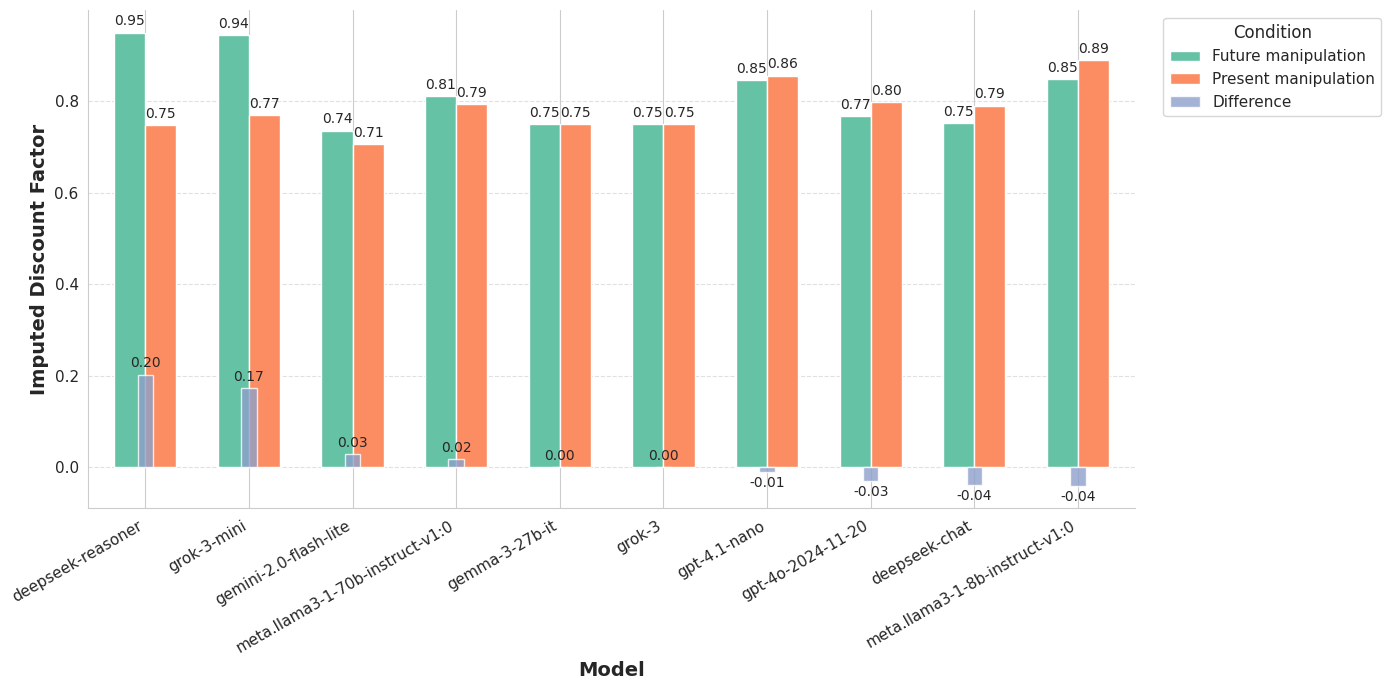

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns

# Set seaborn style for professional look
sns.set_style("whitegrid")

# Directory setup # Update with your path
directory = "/content/drive/MyDrive/Colab Notebooks"

# Load data
file_path = os.path.join(directory, "OverallColabv8.xlsx")
dbb = pd.read_excel(file_path, sheet_name="DB")

# List of models you want to analyze
models = [
    'deepseek-reasoner',
    'meta.llama3-1-70b-instruct-v1:0',
    'grok-3',
    'gemini-2.0-flash-lite',
    'gpt-4o-2024-11-20',
    'gpt-4.1-nano',
    'deepseek-chat',
    'meta.llama3-1-8b-instruct-v1:0',
    'grok-3-mini',
    'gemma-3-27b-it'
]

# Filter the data for the specific prompt_ids and models
desired_ids = ['v1-68', 'v1-69']
filtered_data = dbb[(dbb['prompt_id'].isin(desired_ids)) & (dbb['model'].isin(models))]

# Calculate means for each model and prompt_id
model_means = {}
for model in filtered_data['model'].unique():
    model_data = filtered_data[filtered_data['model'] == model]
    means = {}
    for id_value in desired_ids:
        data_for_id = model_data[model_data['prompt_id'] == id_value]
        means[id_value] = data_for_id['deltabeta'].mean()
    model_means[model] = means

# Convert to DataFrame
means_df = pd.DataFrame(model_means).T
means_df.reset_index(inplace=True)
means_df.columns = ['Model', 'Future manipulation', 'Present manipulation']

# Calculate the difference between the means
means_df['Difference'] = means_df['Future manipulation'] - means_df['Present manipulation']

# Sort by the difference in descending order
means_df = means_df.sort_values(by='Difference', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(14, 7))

# Colors: one for the means (light color) and another for the difference (highlighted color)
bar_colors = sns.color_palette("Set2", 3)  # One more color for difference

# Plotting the means
means_df[['Future manipulation', 'Present manipulation']].plot(
    kind='bar',
    stacked=False,
    color=bar_colors[:2],
    legend=True,
    ax=ax,
    width=0.6  # Adjust width to avoid overlap
)

# Plotting the difference column as a separate bar
ax.bar(
    means_df['Model'],
    means_df['Difference'],
    color=bar_colors[2],
    label='Difference',
    width=0.15,  # Narrower bars for the difference
    alpha=0.8  # Slight transparency to make it stand out
)

# Labels and title
ax.set_ylabel("Imputed Discount Factor", fontsize=14, fontweight='bold')
ax.set_xlabel("Model", fontsize=14, fontweight='bold')
ax.set_xticklabels(means_df['Model'], rotation=30, ha='right', fontsize=11)
ax.tick_params(axis='y', labelsize=11)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10, padding=3)

# Legend formatting
ax.legend(title='Condition', fontsize=11, title_fontsize=12, loc='upper left', bbox_to_anchor=(1.02, 1))

# Clean grid
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
sns.despine()

plt.tight_layout()
plt.show()
